# Frost Risk Model for Strawberry Farm in Plant City, Florida

**Location**: Plant City, FL (Station USC00087203)

**Time Period**: 1991-2020 climatology

**Growing Season**: October - January

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Load Temperature Data for Plant City

Station: USC00087203

In [3]:
# station_id = 'USC00087205'

df = pd.read_csv(
    "s3://noaa-ghcn-pds/csv/by_station/USC00087205.csv",
    storage_options={"anon": True},
    dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
    parse_dates=['DATE']
).set_index('DATE')

/var/folders/60/z6z897c576jdg8k8l0x_yxmc0000gn/T/ipykernel_93031/1004922908.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


## Filter for Temperature Data and Time Period

We need:
- TMIN (minimum temperature) only
- months October-January
- Years 1991-2020

In [4]:
tmin = df[df['ELEMENT'] == 'TMIN'].copy()

# Convert temperature from tenths of degrees C to degrees F
tmin['TEMP_F'] = (tmin['DATA_VALUE'] / 10.0) * 9/5 + 32

tmin = tmin[(tmin.index.year >= 1991) & (tmin.index.year <= 2020)]
tmin = tmin[tmin.index.month.isin([10, 11, 12, 1])]

print(tmin['TEMP_F'].describe())

count    3617.000000
mean       56.570174
std        11.045434
min        17.960000
25%        48.920000
50%        57.920000
75%        64.940000
max        80.060000
Name: TEMP_F, dtype: float64


## Calculate Freeze and Frost Events

- **Freeze**: TMIN ≤ 32F
- **Hard Freeze**: TMIN ≤ 28F

In [5]:
tmin['FREEZE_32'] = tmin['TEMP_F'] <= 32
tmin['FREEZE_28'] = tmin['TEMP_F'] <= 28
tmin['YEAR'] = tmin.index.year
tmin['MONTH'] = tmin.index.month

# For October-December, use that year. For January, use previous year as identifier (so it groups with Oct-Dec of same season)
tmin['SEASON_YEAR'] = tmin['YEAR']
tmin.loc[tmin['MONTH'] == 1, 'SEASON_YEAR'] = tmin.loc[tmin['MONTH'] == 1, 'YEAR'] - 1

tmin.head(20)

,ID,ELEMENT,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,TEMP_F,FREEZE_32,FREEZE_28,YEAR,MONTH,SEASON_YEAR
DATE,,,,,,,,,,,,,
1991-01-01,USC00087205,TMIN,167,NaN,NaN,0,1800.0,62.06,False,False,1991,1,1990
1991-01-02,USC00087205,TMIN,183,NaN,NaN,0,1800.0,64.94,False,False,1991,1,1990
1991-01-03,USC00087205,TMIN,178,NaN,NaN,0,1800.0,64.04,False,False,1991,1,1990
1991-01-04,USC00087205,TMIN,178,NaN,NaN,0,1800.0,64.04,False,False,1991,1,1990
1991-01-05,USC00087205,TMIN,172,NaN,NaN,0,1800.0,62.96,False,False,1991,1,1990
1991-01-06,USC00087205,TMIN,194,NaN,NaN,0,1800.0,66.92,False,False,1991,1,1990
1991-01-07,USC00087205,TMIN,206,NaN,NaN,0,1800.0,69.08,False,False,1991,1,1990
1991-01-08,USC00087205,TMIN,178,NaN,NaN,0,1800.0,64.04,False,False,1991,1,1990
1991-01-09,USC00087205,TMIN,150,NaN,NaN,0,1800.0,59.00,False,False,1991,1,1990


## Calculate Mean Days per Month with Freeze/Frost

**Question 1**: What is the mean risk of frost and freeze?

In [15]:
freeze_counts = tmin.groupby(['SEASON_YEAR', 'MONTH']).agg({
    'FREEZE_32': 'sum',
    'FREEZE_28': 'sum'
}).reset_index()

mean_freeze_by_month = freeze_counts.groupby('MONTH').agg({
    'FREEZE_32': 'mean',
    'FREEZE_28': 'mean'
})


total_freeze_32 = mean_freeze_by_month['FREEZE_32'].sum()
total_freeze_28 = mean_freeze_by_month['FREEZE_28'].sum()

print(mean_freeze_by_month)


       FREEZE_32  FREEZE_28
MONTH                      
1       1.866667   0.500000
10      0.000000   0.000000
11      0.033333   0.000000
12      0.600000   0.166667


## Load ENSO SST Data
Which ENSO index correlates best with freeze events?  

The NOAA CPC provides SST anomalies for the 4 Niño regions:
- Niño 1+2
- Niño 3
- Niño 3.4
- Niño 4

In [7]:
enso_url = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
enso_df = pd.read_csv(enso_url, delim_whitespace=True)

print("ENSO data columns:")
print(enso_df.columns.tolist())
enso_df.head()

/var/folders/60/z6z897c576jdg8k8l0x_yxmc0000gn/T/ipykernel_93031/3343294806.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  enso_df = pd.read_csv(enso_url, delim_whitespace=True)


ENSO data columns:
['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2', 'NINO3.4', 'ANOM.3']


,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49


## Calculate Seasonal ENSO Anomalies

For each growing season (October-January), calculate the mean ENSO index.


In [8]:
print("ENSO data columns:")
print(enso_df.columns.tolist())
print(enso_df.head())

ENSO data columns:
['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2', 'NINO3.4', 'ANOM.3']
     YR  MON  NINO1+2  ANOM  NINO3  ANOM.1  NINO4  ANOM.2  NINO3.4  ANOM.3
0  1982    1    24.28 -0.24  25.84    0.17  28.01   -0.21    26.65    0.08
1  1982    2    25.38 -0.72  26.26   -0.11  27.99   -0.11    26.54   -0.20
2  1982    3    25.22 -1.38  26.92   -0.25  28.18   -0.05    27.09   -0.14
3  1982    4    24.57 -1.16  27.52   -0.05  28.61    0.10    27.83    0.02
4  1982    5    24.00 -0.62  27.70    0.49  29.19    0.40    28.37    0.49


In [9]:
enso_filtered = enso_df[(enso_df['YR'] >= 1991) & (enso_df['YR'] <= 2021)].copy()
enso_filtered = enso_filtered.rename(columns={
    'ANOM': 'NINO12_ANOM',      # NINO1+2
    'ANOM.1': 'NINO3_ANOM',     # NINO3
    'ANOM.2': 'NINO4_ANOM',     # NINO4
    'ANOM.3': 'NINO34_ANOM'     # NINO3.4
})

enso_filtered['SEASON_YEAR'] = enso_filtered['YR']
enso_filtered.loc[enso_filtered['MON'] == 1, 'SEASON_YEAR'] = enso_filtered.loc[enso_filtered['MON'] == 1, 'YR'] - 1
enso_season = enso_filtered[enso_filtered['MON'].isin([10, 11, 12, 1])].copy()
enso_seasonal = enso_season.groupby('SEASON_YEAR').agg({
    'NINO12_ANOM': 'mean',
    'NINO3_ANOM': 'mean',
    'NINO34_ANOM': 'mean',
    'NINO4_ANOM': 'mean'
}).reset_index()

enso_seasonal = enso_seasonal.rename(columns={
    'NINO12_ANOM': 'NINO1+2',
    'NINO3_ANOM': 'NINO3',
    'NINO34_ANOM': 'NINO34',
    'NINO4_ANOM': 'NINO4'
})

print("Seasonal mean ENSO indices (October-January):")
print(enso_seasonal.head(10))

Seasonal mean ENSO indices (October-January):
   SEASON_YEAR  NINO1+2   NINO3  NINO34   NINO4
0         1990  -0.7800 -0.0500  0.3300  0.4000
1         1991   0.2175  0.8025  1.1750  0.6050
2         1992  -0.2100 -0.2075 -0.0950 -0.1050
3         1993  -0.0600  0.0675  0.0975  0.1100
4         1994   0.6150  0.6300  0.8525  0.5825
5         1995  -0.6175 -0.8950 -0.9225 -0.5400
6         1996  -1.0275 -0.8400 -0.5475 -0.2550
7         1997   3.4775  2.8875  2.0500  0.4475
8         1998   0.0425 -0.9850 -1.4900 -1.4975
9         1999  -0.7400 -1.5425 -1.5600 -1.1025


## Calculate Total Freeze Days per Season

In [10]:
seasonal_freeze = freeze_counts.groupby('SEASON_YEAR').agg({
    'FREEZE_32': 'sum',
    'FREEZE_28': 'sum'
}).reset_index()

print("Total freeze days per season:")
print(seasonal_freeze.head(10))

Total freeze days per season:
   SEASON_YEAR  FREEZE_32  FREEZE_28
0         1990          0          0
1         1991          3          0
2         1992          0          0
3         1993          1          0
4         1994          0          0
5         1995          6          3
6         1996          2          1
7         1997          0          0
8         1998          3          3
9         1999          2          0


## Merge ENSO and Freeze Data

In [11]:
combined = pd.merge(seasonal_freeze, enso_seasonal, on='SEASON_YEAR', how='inner')

print("Combined dataset:", len(combined),  "seasons")

Combined dataset: 31 seasons


## Calculate Correlations

**Question 2**: Which ENSO index has the highest absolute correlation with freeze events?

Calculating Pearson correlation coefficients between each ENSO index and the number of freeze days.

In [16]:
# Calculate correlations for 32 degree threshold

enso_indices = ['NINO1+2', 'NINO3', 'NINO34', 'NINO4']
correlations_32 = {}


print("Correlations with number of days >= 32F (Freeze):")
for index in enso_indices:
    r, p_value = stats.pearsonr(combined[index], combined['FREEZE_32'])
    correlations_32[index] = {'r': r, 'p': p_value, 'abs_r': abs(r)}
    print(index.ljust(15) + "r = " + str(r) + "         p-value = " + str(p_value) + "         |r| = " + str(abs(r)))


best_index_32 = max(correlations_32, key=lambda x: correlations_32[x]['abs_r'])
print("Best predictor for 32F:", best_index_32)
print("Correlation coefficient:", correlations_32[best_index_32]['r'])
print("P value:", correlations_32[best_index_32]['p'])


print("Correlations with number of days >= 28F (Hard Freeze):")
correlations_28 = {}
for index in enso_indices:
    r, p_value = stats.pearsonr(combined[index], combined['FREEZE_28'])
    correlations_28[index] = {'r': r, 'p': p_value, 'abs_r': abs(r)}
    print(index.ljust(15) + "r = " + str(r) + "         p-value = " + str(p_value) + "         |r| = " + str(abs(r)))


best_index_28 = max(correlations_28, key=lambda x: correlations_28[x]['abs_r'])
print("Best predictor for 28F:", best_index_28)
print("Correlation coefficient:", correlations_28[best_index_28]['r'])
print("P value:", correlations_28[best_index_28]['p'])

Correlations with number of days >= 32F (Freeze):
NINO1+2        r = -0.27770560417890844         p-value = 0.13038369488570378         |r| = 0.27770560417890844
NINO3          r = -0.2619353229017761         p-value = 0.15460419858914473         |r| = 0.2619353229017761
NINO34         r = -0.26861718833442016         p-value = 0.14397521101606947         |r| = 0.26861718833442016
NINO4          r = -0.322640478472765         p-value = 0.07668526311469814         |r| = 0.322640478472765
Best predictor for 32F: NINO4
Correlation coefficient: -0.322640478472765
P value: 0.07668526311469814
Correlations with number of days >= 28F (Hard Freeze):
NINO1+2        r = -0.21996987272806967         p-value = 0.23442293973197564         |r| = 0.21996987272806967
NINO3          r = -0.2344357794513084         p-value = 0.20429040372738344         |r| = 0.2344357794513084
NINO34         r = -0.25028032962413976         p-value = 0.17447474508967684         |r| = 0.25028032962413976
NINO4          r

## Relationship between the best ENSO index and freeze days

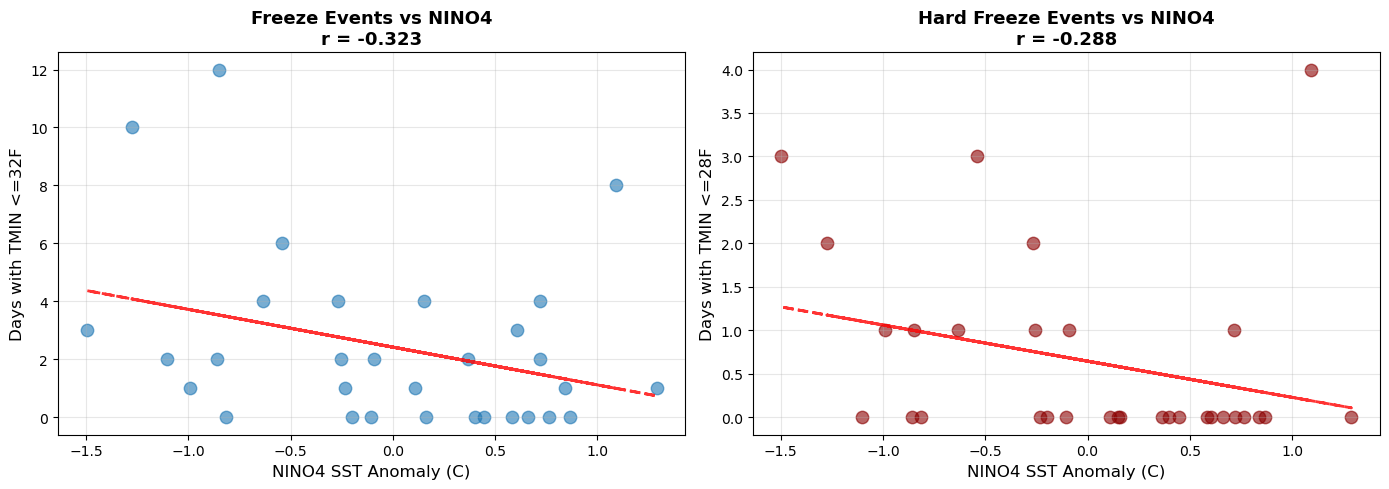

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 32F threshold Plot
ax1.scatter(combined[best_index_32], combined['FREEZE_32'], alpha=0.6, s=80)
ax1.set_xlabel(f'{best_index_32} SST Anomaly (C)', fontsize=12)
ax1.set_ylabel('Days with TMIN <=32F', fontsize=12)
ax1.set_title(f'Freeze Events vs {best_index_32}\nr = {correlations_32[best_index_32]["r"]:.3f}', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
z = np.polyfit(combined[best_index_32], combined['FREEZE_32'], 1)
p = np.poly1d(z)
ax1.plot(combined[best_index_32], p(combined[best_index_32]), "r--", alpha=0.8, linewidth=2)

# 28F threshold Plot
ax2.scatter(combined[best_index_28], combined['FREEZE_28'], alpha=0.6, s=80, color='darkred')
ax2.set_xlabel(f'{best_index_28} SST Anomaly (C)', fontsize=12)
ax2.set_ylabel('Days with TMIN <=28F', fontsize=12)
ax2.set_title(f'Hard Freeze Events vs {best_index_28}\nr = {correlations_28[best_index_28]["r"]:.3f}', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
z = np.polyfit(combined[best_index_28], combined['FREEZE_28'], 1)
p = np.poly1d(z)
ax2.plot(combined[best_index_28], p(combined[best_index_28]), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

## Time Series

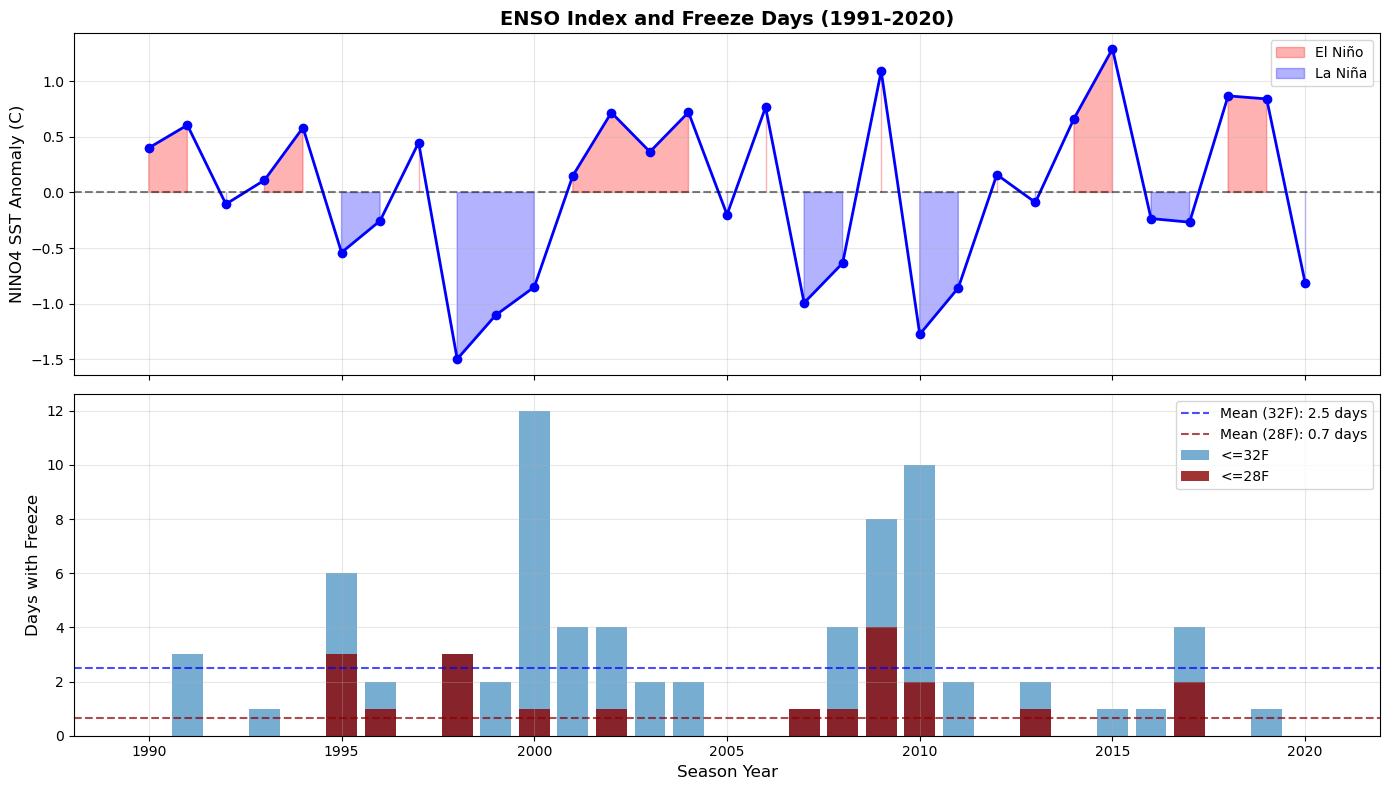

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# ENSO index
ax1.plot(combined['SEASON_YEAR'], combined[best_index_32], 'b-', linewidth=2, marker='o')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.fill_between(combined['SEASON_YEAR'], 0, combined[best_index_32], 
                  where=combined[best_index_32]>=0, alpha=0.3, color='red', label='El Niño')
ax1.fill_between(combined['SEASON_YEAR'], 0, combined[best_index_32], 
                  where=combined[best_index_32]<0, alpha=0.3, color='blue', label='La Niña')
ax1.set_ylabel(f'{best_index_32} SST Anomaly (C)', fontsize=12)
ax1.set_title('ENSO Index and Freeze Days (1991-2020)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Freeze days
ax2.bar(combined['SEASON_YEAR'], combined['FREEZE_32'], alpha=0.6, label='<=32F')
ax2.bar(combined['SEASON_YEAR'], combined['FREEZE_28'], alpha=0.8, color='darkred', label='<=28F')
ax2.axhline(y=total_freeze_32, color='blue', linestyle='--', alpha=0.7, label=f'Mean (32F): {total_freeze_32:.1f} days')
ax2.axhline(y=total_freeze_28, color='darkred', linestyle='--', alpha=0.7, label=f'Mean (28F): {total_freeze_28:.1f} days')
ax2.set_xlabel('Season Year', fontsize=12)
ax2.set_ylabel('Days with Freeze', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Questions

### Question 1: Mean Risk of Frost and Freeze
Strawberries are planted around October 1 and ready for harvest by the end of January. What is the mean risk of frost and freeze, defined as the mean number of days per month over the period 1991-2020 that the temperature has been observed to be less than or equal to 32 and 28 degrees Fahrenheit, respectively, that might damage the plants for each month during the October - January period? (25 points)
    
     

  
| MONTH | FREEZE_32 | FREEZE_28 |
| ----- | --------- | ----------|                 
| 1     | 1.866667  | 0.500000  |
| 10    | 0.000000  | 0.000000  |
| 11    | 0.033333  | 0.000000  |
| 12    | 0.600000  | 0.166667  |

For Plant City, Florida between 1991-2020:  
The mean number of days in October that are at or below 32F is 0, and below 28F is also 0.  
The mean number of days in November that are at or below 32F is 0.03, and below 28F is 0.  
The mean number of days in December that are at or below 32F is 0.6, and below 28F is 0.17.  
The mean number of days in January that are at or below 32F is 1.87, and below 28F is 0.5.  

January is the riskiest month for strawberries in Plant City, Florida.  


### Question 2: Best ENSO Predictor
To begin to explore the seasonal to sub-seasonal prediction of freeze events at this site, using code you adapt from Module 4, we're going to try to relate these cold events to the El Nino Southern Oscillation (ENSO).  You have a hypothesis that ENSO is related to seasonal prediction of freeze events, but you don't know which region to choose for calculating your anomalies.  The problem is that there are many ENSO indicies that represent forcing across the eastern and central Pacific: which SST forcing region is most related to cold conditions in central Florida? NOAA CPC has calculated mean SSTs and anomalies in each of these 4 regions (cpc.ncep.noaa.gov/data/indices/sstoi.indicesLinks to an external site.). Using the temperature anomalies computed in the file, determine which ENSO index (NINO1+2, NINO3, NINO4, and NINO3.4) is best correlated (i.e., has the highest absolute value of Pearson's correlation coefficient) with the number of days per month < 28 degrees F.  (25 points)
  
  
    
      
The ENSO index with the highest absolute value of Pearson Correlation Coefficient is NINO4, for both 32 degree and 28 degree thresholds. This means that in years with larger negative values for NINO4 index, there is a higher risk for freezes and hard freeze days. NINO4 is the furthest west ENSO region, which has teleconnections to the southeastern U.S. (like central Florida). The P values were not significant for either freeze or hard freeze, even for NINO4.

* La Niña conditions (negative NINO4 anomaly) means more freeze days in Plant City / higher risk for strawberries
* El Niño conditions (positive NINO4 anomaly) means frewer freeze days in Plant City / lower risk for strawberries

Best predictor for 32F: NINO4  
Correlation coefficient: -0.322640478472765  
P value: 0.07668526311469814  
  
Best predictor for 28F: NINO4  
Correlation coefficient: -0.2876863943884821  
P value: 0.11657072154128326  


